In [18]:
import tqdm
import mlmi
import mlmi3
import numpy as np
import scipy.stats
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
sns.set_style('ticks')

In [2]:
cov = [[1, 0.5, 0],
       [0.5, 1, 0],
       [0, 0, 1]]
print(np.array(cov))
X = scipy.stats.multivariate_normal(mean=[0, 0, 0], cov=cov).rvs(3000)

[[ 1.   0.5  0. ]
 [ 0.5  1.   0. ]
 [ 0.   0.   1. ]]


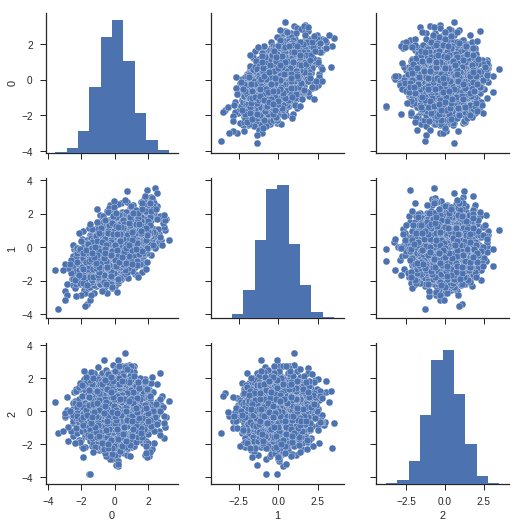

In [3]:
sns.pairplot(pd.DataFrame(X))

In [4]:
ami = np.zeros([3, 3])
for i, j in [(0, 1), (0, 2), (1, 2)]:
    ami[j, i] = ami[i, j] = mlmi.mutual_information(X[:, [i, j]], n_b=200)
    print('(%d, %d): %f' % (i, j, ami[i, j]))

(0, 1): 0.152980
(0, 2): 0.002041
(1, 2): 0.003402


In [5]:
ami3 = mlmi3.mutual_information(X, n_b=200)
print('(0, 1, 2): %f' % ami3)

(0, 1, 2): 0.150921


In [6]:
print('I(X, Y | Z) = %f' % (ami3 - ami[0, 2] - ami[1, 2]))
print('I(X, Z | Y) = %f' % (ami3 - ami[0, 1] - ami[2, 1]))
print('I(Y, Z | X) = %f' % (ami3 - ami[1, 0] - ami[2, 0]))

I(X, Y | Z) = 0.145478
I(X, Z | Y) = -0.005461
I(Y, Z | X) = -0.004100


In [26]:
cov = [[1,   0.5,    0,    0],
       [0.5,   1,  0.4,    0],
       [0,     0,    1, -0.3],
       [0,   0.4, -0.3,    1]]
print(np.array(cov))
X = scipy.stats.multivariate_normal(mean=[0, 0, 0, 0], cov=cov).rvs(3000)

[[ 1.   0.5  0.   0. ]
 [ 0.5  1.   0.4  0. ]
 [ 0.   0.   1.  -0.3]
 [ 0.   0.4 -0.3  1. ]]


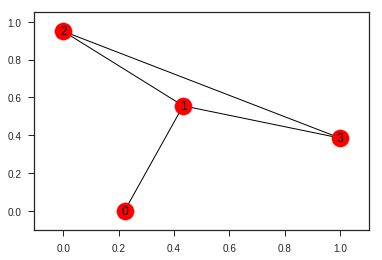

In [27]:
g = nx.from_numpy_matrix(np.array(cov))
nx.draw_networkx(g)

In [17]:
ami = np.zeros([4, 4])
for i, j in [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]:
    ami[j, i] = ami[i, j] = mlmi.mutual_information(X[:, [i, j]], n_b=200)

ami

array([[ 0.        ,  0.13971129,  0.00356299,  0.00237144],
       [ 0.13971129,  0.        ,  0.01471621,  0.0364224 ],
       [ 0.00356299,  0.01471621,  0.        ,  0.05175902],
       [ 0.00237144,  0.0364224 ,  0.05175902,  0.        ]])